<a href="https://colab.research.google.com/github/sahinya17/ANN-Electricity-data/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# install.packages("keras")
# install.packages("tensorflow")
# library(tensorflow)
# install_tensorflow(method = "auto")

# library(keras)
# install_keras(method = c("conda"), conda = "auto", tensorflow = "default",
#               extra_packages = c("tensorflow-hub"))

# install.packages("tidyverse")
# install.packages("DataExplorer")
# install.packages("caret")
# install.packages("tidyr")

NULL


In [4]:
%%R
library(tidyverse)
library(DataExplorer)
library(tensorflow)
library(keras)
library(caret)
library(tidyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Attaching package: ‘caret’



    train



    lift




In [5]:
%%R
# convert an array of values into a dataset matrix
create_dataset <- function(dataset, look_back = 1){
    dataX = array(0, dim = c(length(dataset)-look_back-1, look_back))
    dataY = array(0, dim = length(dataset)-look_back-1)
    for (i in 1:(length(dataset)-look_back-1)){
        a <- dataset[i:(i + look_back -1)]
        dataX[i, ] <- a
        dataY[i] <- dataset[i+look_back]
    }
    return (list(dataX, dataY))
}

# fix random seed for reproducibility
set.seed(7)

# load the dataset
dataframe = read.csv("Electricity_data_Poland.csv") %>% select(totalLoad)  %>% 
mutate(totalLoad = as.numeric(totalLoad))
dataframe = dataframe %>% fill(totalLoad)
dataset = as.matrix(dataframe[,1])

In [6]:
%%R
# normalize the dataset
normalize <- function(x, na.rm = TRUE) {
    return((x- min(x)) /(max(x)-min(x)))
}
denormalize <- function(x, min, max){
    return(x * (max - min) + min)
}
min = min(dataset)
max = max(dataset)
dataset <- normalize(dataset)

In [7]:
%%R
# split into train and test sets
train_size = length(dataset) * 0.67
test_size = length(dataset) - train_size
train = as.matrix(dataset[0:train_size])
test = as.matrix(dataset[train_size:length(dataset)])

In [8]:
%%R
look_back = 365
train_data = create_dataset(train, look_back)
test_data = create_dataset(test, look_back)
trainX = train_data[[1]]
trainY = train_data[[2]]
testX = test_data[[1]]
testY = test_data[[2]]

In [9]:
%%R
# reshape input to be [samples, time steps, features]
dim(trainX) = c(dim(trainX)[1], 1, dim(trainX)[2])
dim(testX) = c(dim(testX)[1], 1, dim(testX)[2])

In [10]:
%%R
# create and fit the LSTM network
model <- keras_model_sequential() 
model %>% 
  layer_lstm(units = 4, input_shape=c(1, look_back)) %>% 
  layer_dense(units = 1, activation = 'relu') %>% 
  compile(optimizer = 'adam', loss = 'mean_squared_error')

history <- model %>% fit(trainX, trainY, epochs=1, batch_size=1)

40750/40750 [==============================] - 100s 2ms/step - loss: 0.0020


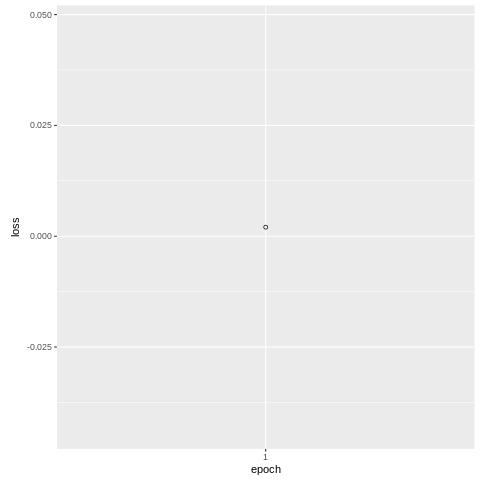

In [11]:
%%R
plot(history)

In [12]:
%%R
# make predictions
trainPredict = model %>% predict(trainX)
testPredict = model %>% predict(testX)

622/622 [==============================] - 1s 1ms/step


In [13]:
%%R
# invert predictions
trainPredict = denormalize(trainPredict, min, max)
trainY = denormalize(trainY, min, max)
testPredict = denormalize(testPredict, min, max)
testY = denormalize(testY, min, max)

In [14]:
%%R
str(trainY)
str(trainPredict[,1])

 num [1:40750(1d)] 20115 21594 22076 22297 22128 ...
 num [1:40750] 19152 21201 22274 22774 22953 ...


In [15]:
%%R
# calculate root mean squared error
mean_squared_error <- function(x, y){
    mean((x - y)^2)
}
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY, trainPredict[,1]))
print(paste0('Train Score: ', trainScore, ' RMSE'))
testScore = sqrt(mean_squared_error(testY, testPredict[,1]))
print(paste0('Test Score: ', testScore, ' RMSE'))

[1] "Train Score: 434.260393130935 RMSE"
[1] "Test Score: 489.460734931975 RMSE"


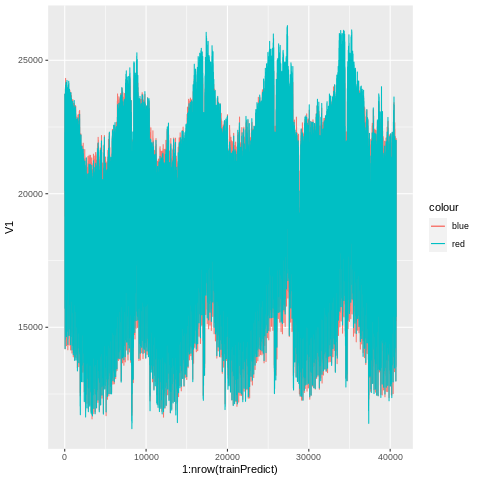

In [16]:
%%R
library(ggplot2)
trainPredict = as.data.frame(trainPredict)
plot_full_data <- as.data.frame(denormalize(dataset, min, max))
trainY = as.data.frame(trainY)
colnames(trainY) <- 'V1'
ggplot(trainPredict, aes(x = 1:nrow(trainPredict))) +
  geom_line(aes(y = V1, color = 'blue'), group = 1) +
  geom_line(aes(y = trainY$V1, color = 'red'),group = 1)

In [17]:
%%R
testPredict = as.data.frame(testPredict)
colnames(testPredict) <- 'V1'
# plot_full_data <- as.data.frame(denormalize(dataset, min, max))
# trainY = as.data.frame(trainY)
# colnames(trainY) <- 'V1'
# ggplot(testPredict, aes(x = 1:nrow(testPredict))) +
#   geom_line(aes(y = V1, color = 'blue'), group = 1) 
  # +
  # geom_line(aes(y = trainY$V1, color = 'red'),group = 1)

In [ ]:
%%R
ggplot(testPredict, aes(x = 1:nrow(testPredict))) +
geom_line(aes(y = V1, color = 'blue'), group = 1)